# 卷积网络的热图生成

首先查看分类输出，只查看这个输出值。滑动一个小的图像，修改图像输入为0，观察分类输出的值，由这个值来绘制所谓热图。

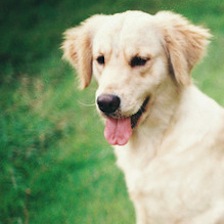

   3
 224
 224
[torch.LongStorage of size 3]



In [2]:
require('nn')
require('image')
require('loadcaffe')
require('cunn')

torch.setdefaulttensortype('torch.FloatTensor')


-- 准备输入图像
imgFile = './dog.png'
--imgFile = './lion.png'
ximg = image.loadPNG(imgFile, 3)
itorch.image(ximg)
ximg = ximg:float() * 256
ximg[1] = ximg[1] - 103.939
ximg[2] = ximg[2] - 116.779
ximg[3] = ximg[3] - 123.68


print(ximg:size())

In [2]:
-- 载入分类文本
classText = torch.load('synset.t7','ascii')
-- 加载模型文件
cnn = loadcaffe.load('vgg19/VGG_ILSVRC_19_layers_deploy.prototxt', 'vgg19/VGG_ILSVRC_19_layers.caffemodel', 'nn')
cnn:evaluate()

Successfully loaded vgg19/VGG_ILSVRC_19_layers.caffemodel


conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3


conv3_1: 256 128 3 3
conv3_2: 256 256 3 3
conv3_3: 256 256 3 3


conv3_4: 256 256 3 3


conv4_1: 512 256 3 3


conv4_2: 512 512 3 3


conv4_3: 512 512 3 3


conv4_4: 512 512 3 3


conv5_1: 512 512 3 3


conv5_2: 512 512 3 3


conv5_3: 512 512 3 3


conv5_4: 512 512 3 3


fc6: 1 1 25088 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


In [3]:
-- 直接得到分类结果
local score, obj = cnn:forward(ximg):max(1)
targetObj = obj[1]
print(score[1] .. " : " .. classText[obj[1]])

0.2681924700737 : lion, king of beasts, Panthera leo	


In [4]:
local K = 32  --用8x8的去mask原图
local S = 3
local W,H = 224,224
heatMap = torch.zeros(math.floor((W-K+1)/S+1), math.floor((H-K+1)/S+1) )
local xx,yy = 1,1

cnn:cuda()
ximg = ximg:cuda()

for y = 1, H-K+1, S do
    xx = 1
    for x = 1, W-K+1, S do
        local xximg = ximg:clone()
        xximg[{{},{y,y+K-1},{x,x+K-1} }] = -128
        local scores = cnn:forward(xximg)
        
        heatMap[yy][xx] = scores[targetObj]
        
        xx = xx + 1
    end
    yy = yy + 1
end

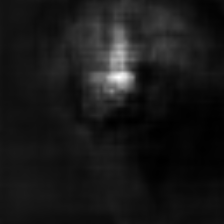

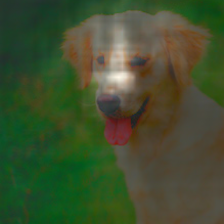

In [6]:
heatBMP = heatMap:clone()

local maxv = heatBMP:max()
local minv = heatBMP:min()
heatBMP = heatBMP - minv
heatBMP = heatBMP / (maxv - minv)
heatBMP = heatBMP * (-1) + 1

heatBMP = image.scale(heatBMP, 224, 224)
local showImage = image.loadPNG(imgFile, 3)
showImage = image.rgb2yuv(showImage)
showImage[1] = (heatBMP * 4 + showImage[1]) / 5
showImage = image.yuv2rgb(showImage)

itorch.image(heatBMP)
itorch.image(showImage)

